This image is with dimensions: (540, 960, 3)


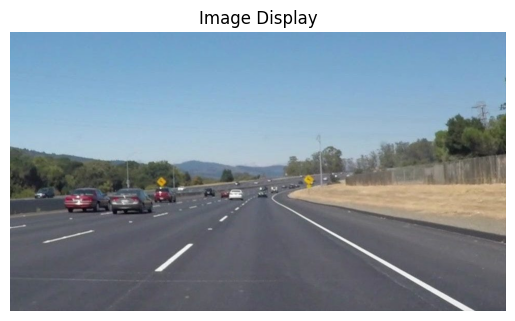

In [ ]:
import cv2
import matplotlib.pyplot as plt


image = cv2.imread("road.png")  # Reads the image as a NumPy array (BGR format)
# Print stats
print('This image is with dimensions:', image.shape)

# Convert BGR to RGB for correct color display
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot the image
plt.imshow(image_rgb)
plt.axis('off')  # Hide axes
plt.title("Image Display")
plt.show()


region_of_interest_vertices = [

    (0, height),
    (width / 2, height / 2),
    (width, height),
]

A polygon of Triangle will get the roi

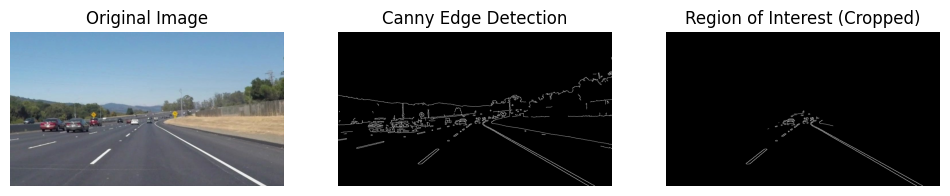

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    match_mask_color = 255  #grayscale
    cv2.fillPoly(mask, [vertices], match_mask_color) #fill polygon with mask
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image



image = cv2.imread("road.png")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #to rgb
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)# to grayscale

canny_image = cv2.Canny(gray_image, 100, 200)
#did canny before roi to avoid detecting edge of roi

height, width = gray_image.shape
roi_vertices = np.array([
    (0, height),
    (width // 2, height // 2),
    (width, height)
], dtype=np.int32)

cropped_image = region_of_interest(canny_image, np.array([roi_vertices]))

# Display original, grayscale, and processed images
plt.figure(figsize=(12, 4))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis("off")

# Canny edge detected image
plt.subplot(1, 3, 2)
plt.imshow(canny_image, cmap="gray")
plt.title("Canny Edge Detection")
plt.axis("off")

# Cropped image with region of interest
plt.subplot(1, 3, 3)
plt.imshow(cropped_image, cmap="gray")
plt.title("Region of Interest (Cropped)")
plt.axis("off")

plt.show()


In [ ]:

def hough_transform(edges, rho_res=1, theta_res=np.pi/50, threshold=105):
    """Perform Hough Transform and return detected lines (rho, theta)."""
    height, width = edges.shape
    rho_max = int(np.hypot(height, width))  # Maximum possible rho
    rhos = np.arange(-rho_max, rho_max, rho_res)
    thetas = np.arange(-np.pi / 2, np.pi / 2, theta_res)

    accumulator = np.zeros((len(rhos), len(thetas)), dtype=np.int32)
    edge_points = np.argwhere(edges)  # Get edge pixel coordinates

    for y, x in edge_points:
        for theta_idx, theta in enumerate(thetas):
            rho = int(x * np.cos(theta) + y * np.sin(theta))
            rho_idx = np.searchsorted(rhos, rho)
            if 0 <= rho_idx < len(rhos):
                accumulator[rho_idx, theta_idx] += 1

    # Extract lines above threshold
    lines = []
    for rho_idx, theta_idx in zip(*np.where(accumulator >= threshold)):
        rho = rhos[rho_idx]
        theta = thetas[theta_idx]
        lines.append((rho, theta))

    return lines

In [ ]:
def draw_hough_lines(image, lines):
    """Draw detected lines on the image."""
    for rho, theta in lines:
        a, b = np.cos(theta), np.sin(theta)
        x0, y0 = a * rho, b * rho
        x1, y1 = int(x0 + 1000 * (-b)), int(y0 + 1000 * (a))
        x2, y2 = int(x0 - 1000 * (-b)), int(y0 - 1000 * (a))
        cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    return image


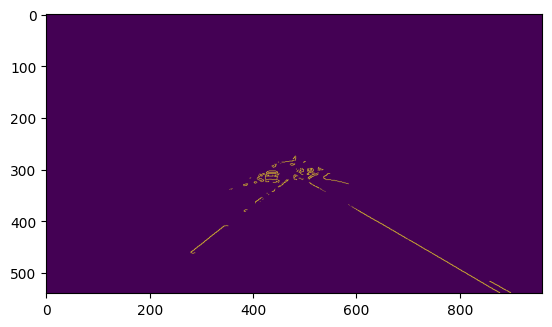

In [ ]:
lines = hough_transform(cropped_image)
hough_image = draw_hough_lines(cropped_image.copy(), lines)
plt.figure()
plt.imshow(hough_image)
plt.show()

In [ ]:

def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    """Draw Hough lines on an image."""
    if lines is None or len(lines) == 0:
        return img  # If no lines, return original image

    # Make a copy of the original image
    img_copy = np.copy(img)

    # Create a blank image (same size as original)
    line_img = np.zeros_like(img_copy)

    for rho, theta in lines:
        a, b = np.cos(theta), np.sin(theta)
        x0, y0 = a * rho, b * rho
        y1=550
        y2=300
        x1= int((rho-y1*b)/a)
        x2= int((rho-y2*b)/a)
        cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)

    # Merge the lines with the original image
    img_with_lines = cv2.addWeighted(img_copy, 0.8, line_img, 1.0, 0.0)
    return img_with_lines

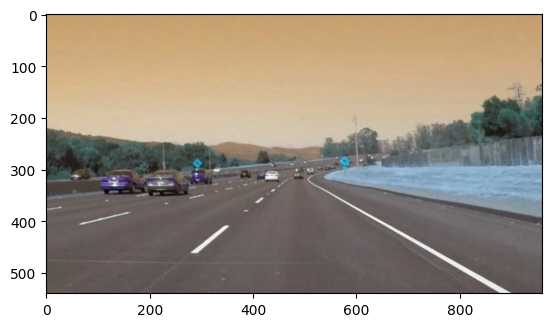

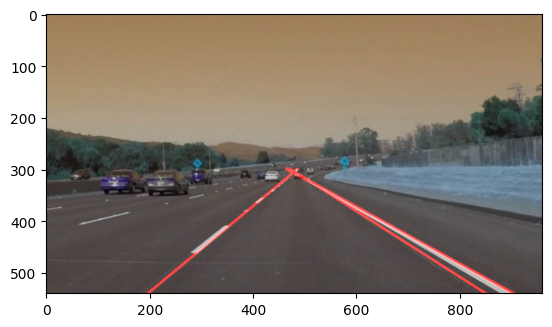

In [ ]:
plt.figure()
plt.imshow(image)
plt.show()
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
cannyed_image = cv2.Canny(gray_image, 50, 150)
cropped_image = region_of_interest(
    cannyed_image,
    np.array(
        [roi_vertices],
        np.int32
    ),
)
lines =hough_transform(cropped_image)
line_image = draw_lines(image, lines)
plt.figure()
plt.imshow(line_image)
plt.show()

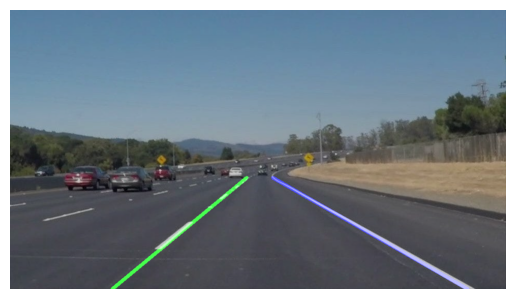

In [ ]:
def filter_lanes(lines):
    """Separate left and right lane lines using polar coordinates (rho, theta)."""
    left_lines = []
    right_lines = []

    if lines is None:
        return left_lines, right_lines

    for rho, theta in lines:
        if abs(np.tan(theta)) < 0.5:
            continue
        if theta > np.pi / 4:  # Around 45° to 90° (upward lines)
            left_lines.append((rho, theta))
        elif theta < np.pi / 4:  # Around 0° to 45° (downward lines)
            right_lines.append((rho, theta))
    return left_lines, right_lines

def average_slope_intercept(lines_polar, img_height, y_top_ratio=0.6):
    """Compute the best-fit single lane line using polar coordinates."""
    if not lines_polar:
        return None  # No lane detected

    # Convert polar lines to Cartesian points
    x_vals, y_vals = [], []
    for rho, theta in lines_polar:
        cos_t, sin_t = np.cos(theta), np.sin(theta)
        x0, y0 = rho * cos_t, rho * sin_t  # Base point on the line

        # Two far points along the line
        x1, y1 = int(x0 + 1000 * (-sin_t)), int(y0 + 1000 * (cos_t))
        x2, y2 = int(x0 - 1000 * (-sin_t)), int(y0 - 1000 * (cos_t))

        x_vals.extend([x1, x2])
        y_vals.extend([y1, y2])

    if len(x_vals) < 2:
        return None  # Not enough points for fitting

    # Fit a line (y = mx + b), solve for x in terms of y (x = ay + b)
    coefficients = np.polyfit(y_vals, x_vals, 1)
    line_func = np.poly1d(coefficients)

    # Define y values for bottom and top of the lane
    y_bottom = img_height  # Bottom of the image
    y_top = int(img_height * y_top_ratio)  # 60% of the height (horizon level)

    # Compute x values from the function
    x_bottom = int(line_func(y_bottom))
    x_top = int(line_func(y_top))

    return (x_bottom, y_bottom, x_top, y_top)  # Final single line

def draw_lanes(image, left_lane, right_lane):
    """Draw final lane lines on image."""
    lane_image = np.zeros_like(image)
    if left_lane:
        cv2.line(lane_image, (left_lane[0], left_lane[1]), (left_lane[2], left_lane[3]), (255, 0, 0), 5)
    if right_lane:
        cv2.line(lane_image, (right_lane[0], right_lane[1]), (right_lane[2], right_lane[3]), (0, 255, 0), 5)
    return cv2.addWeighted(image, 0.8, lane_image, 1, 0)


lines = hough_transform(cropped_image, rho_res=1, theta_res=np.pi/50, threshold=105)

left_lines, right_lines = filter_lanes(lines)

left_lane = average_slope_intercept( left_lines,540)
right_lane = average_slope_intercept( right_lines,540)

output = draw_lanes(image, right_lane,left_lane)

# Display result
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()
